# Problem Statement

This project's objective is to use historical data to forecast consumer satisfaction. This entails creating a predictive model by analysing variables that affect customer satisfaction using machine learning algorithms.

In [1]:
import pandas as pd
import numpy as np

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For feature engineering and preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## For model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from mord import LogisticAT
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb

In [3]:
# Read data into dataframe
df = pd.read_csv("../data/customer_support_tickets.csv") 

## Data Description

In [4]:
df.head(15)

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
5,6,Rebecca Fleming,sheenasmith@example.com,53,Male,Microsoft Office,2020-07-28,Cancellation request,Payment issue,I'm facing a problem with my {product_purchase...,Open,NaN,Low,Social media,NaN,NaN,NaN
6,7,Jacqueline Wright,donaldkeith@example.org,24,Other,Microsoft Surface,2020-02-23,Product inquiry,Refund request,I'm unable to access my {product_purchased} ac...,Open,NaN,Critical,Social media,NaN,NaN,NaN
7,8,Denise Lee,joelwilliams@example.com,23,Male,Philips Hue Lights,2020-08-09,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Social media,NaN,NaN,NaN
8,9,Nicolas Wilson,joshua24@example.com,60,Other,Fitbit Versa Smartwatch,2020-07-16,Technical issue,Installation support,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Low,Social media,2023-06-01 10:32:47,NaN,NaN
9,10,William Dawson,clopez@example.com,27,Male,Dyson Vacuum Cleaner,2020-03-06,Refund request,Payment issue,My {product_purchased} is making strange noise...,Pending Customer Response,NaN,Critical,Phone,2023-06-01 09:25:48,NaN,NaN


In [5]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [6]:
df.describe()

,Ticket ID,Customer Age,Customer Satisfaction Rating
count,8469.000000,8469.000000,2769.000000
mean,4235.000000,44.026804,2.991333
std,2444.934048,15.296112,1.407016
min,1.000000,18.000000,1.000000
25%,2118.000000,31.000000,2.000000
50%,4235.000000,44.000000,3.000000
75%,6352.000000,57.000000,4.000000
max,8469.000000,70.000000,5.000000


# Data Cleaning And Preprocessing

In [7]:
df[['Date of Purchase', 'Time to Resolution', 'First Response Time']] = df[['Date of Purchase', 'Time to Resolution', 'First Response Time']].apply(pd.to_datetime, errors='coerce')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Ticket ID                     8469 non-null   int64         
 1   Customer Name                 8469 non-null   object        
 2   Customer Email                8469 non-null   object        
 3   Customer Age                  8469 non-null   int64         
 4   Customer Gender               8469 non-null   object        
 5   Product Purchased             8469 non-null   object        
 6   Date of Purchase              8469 non-null   datetime64[ns]
 7   Ticket Type                   8469 non-null   object        
 8   Ticket Subject                8469 non-null   object        
 9   Ticket Description            8469 non-null   object        
 10  Ticket Status                 8469 non-null   object        
 11  Resolution                    

In [8]:
# Check for missing values and duplicates

# missing values
print(f'Missing Values: \n{pd.isna(df).sum()}')

Missing Values: 
Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64


## Check for duplicated names and emails

Since people can share the same name, duplicates from the **Customer Name** column will not be dropped.

Also, since names share the duplicated emails with different entries, duplicated **Customer Emails** will not be dropped. 

In [9]:
df.nunique()

Ticket ID                       8469
Customer Name                   8028
Customer Email                  8320
Customer Age                      53
Customer Gender                    3
Product Purchased                 42
Date of Purchase                 730
Ticket Type                        5
Ticket Subject                    16
Ticket Description              8077
Ticket Status                      3
Resolution                      2769
Ticket Priority                    4
Ticket Channel                     4
First Response Time             5470
Time to Resolution              2728
Customer Satisfaction Rating       5
dtype: int64

In [10]:
duplicated = df[df.duplicated(subset=['Customer Email'], keep=False)]
print('Duplicated Names and Emails: \n')
duplicated.head(10)

Duplicated Names and Emails: 



,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
45,46,Timothy Sutton,david40@example.org,65,Female,LG Smart TV,2021-02-01,Product inquiry,Cancellation request,I'm having an issue with the {product_purchase...,Open,NaN,Low,Chat,NaT,NaT,NaN
47,48,Kristen Perry,bevans@example.org,27,Female,GoPro Hero,2020-07-29,Technical issue,Software bug,I'm having an issue with the {product_purchase...,Closed,Late center interview that.,Medium,Social media,2023-06-01 07:16:45,2023-06-01 05:59:45,1.0
94,95,Scott Estrada,davidcox@example.org,65,Other,Microsoft Xbox Controller,2021-12-06,Product inquiry,Account access,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Phone,NaT,NaT,NaN
106,107,Miranda Morales,daniellebrown@example.net,42,Female,Nintendo Switch,2021-05-20,Cancellation request,Installation support,I'm having an issue with the {product_purchase...,Closed,Table admit really Mrs development move.,Low,Email,2023-06-01 11:38:01,2023-06-01 20:46:01,2.0
111,112,Autumn Heath,matthew17@example.com,68,Male,Nintendo Switch Pro Controller,2021-11-29,Refund request,Display issue,I'm having an issue with the {product_purchase...,Open,NaN,High,Phone,NaT,NaT,NaN
125,126,Austin Murphy,daniel46@example.com,45,Male,Philips Hue Lights,2020-06-27,Refund request,Display issue,I'm having an issue with the {product_purchase...,Open,NaN,Medium,Chat,NaT,NaT,NaN
156,157,Thomas Prince,rogergriffin@example.net,20,Male,Asus ROG,2020-12-11,Product inquiry,Delivery problem,I'm having an issue with the {product_purchase...,Open,NaN,Low,Social media,NaT,NaT,NaN
177,178,Michelle Payne,matthewlewis@example.org,27,Other,Dyson Vacuum Cleaner,2020-09-21,Cancellation request,Product recommendation,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Phone,2023-06-01 11:03:49,NaT,NaN
185,186,Kaitlyn Rose,jamiesmith@example.com,50,Other,Sony 4K HDR TV,2021-03-19,Technical issue,Software bug,There seems to be a glitch in the {product_pur...,Open,NaN,Low,Phone,NaT,NaT,NaN
205,206,Mary Williams,jennifer22@example.net,55,Male,Sony Xperia,2020-11-24,Refund request,Delivery problem,I'm having an issue with the {product_purchase...,Closed,Employee support economy themselves should rem...,Medium,Phone,2023-06-01 13:56:29,2023-06-01 11:18:29,1.0


In [11]:
duplicated[duplicated['Customer Email'] == 'matthew17@example.com']

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
111,112,Autumn Heath,matthew17@example.com,68,Male,Nintendo Switch Pro Controller,2021-11-29,Refund request,Display issue,I'm having an issue with the {product_purchase...,Open,NaN,High,Phone,NaT,NaT,NaN
2899,2900,Andrew Wells,matthew17@example.com,70,Male,Asus ROG,2021-12-08,Cancellation request,Display issue,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Chat,2023-06-01 21:02:23,NaT,NaN


In [12]:
duplicated[duplicated['Customer Email'] == 'david40@example.org']

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
45,46,Timothy Sutton,david40@example.org,65,Female,LG Smart TV,2021-02-01,Product inquiry,Cancellation request,I'm having an issue with the {product_purchase...,Open,NaN,Low,Chat,NaT,NaT,NaN
8101,8102,Patricia Wang,david40@example.org,29,Male,LG OLED,2020-02-08,Cancellation request,Hardware issue,I'm having an issue with the {product_purchase...,Closed,International radio dog morning project series.,Low,Phone,2023-06-01 10:21:05,2023-06-01 01:10:05,2.0


In [13]:
duplicated[duplicated['Customer Email'] == 'matthewlewis@example.org']

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
177,178,Michelle Payne,matthewlewis@example.org,27,Other,Dyson Vacuum Cleaner,2020-09-21,Cancellation request,Product recommendation,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Phone,2023-06-01 11:03:49,NaT,NaN
3140,3141,Steven Atkins,matthewlewis@example.org,32,Male,GoPro Action Camera,2020-03-02,Product inquiry,Battery life,I've encountered a data loss issue with my {pr...,Closed,Receive firm itself past four.,Medium,Phone,2023-06-01 13:23:00,2023-06-01 07:50:00,4.0


# Exploratoratory Data Analysis


### Top 10 Products Purchased

In [14]:
top_products_purchased = df["Product Purchased"].value_counts().head(10)
print(top_products_purchased)

Product Purchased
Canon EOS              240
GoPro Hero             228
Nest Thermostat        225
Philips Hue Lights     221
Amazon Echo            221
LG Smart TV            219
Sony Xperia            217
Roomba Robot Vacuum    216
Apple AirPods          213
LG OLED                213
Name: count, dtype: int64


### Top Ticket Types

In [15]:
top_ticket_type = df["Ticket Type"].value_counts().head()
print(top_ticket_type)

Ticket Type
Refund request          1752
Technical issue         1747
Cancellation request    1695
Product inquiry         1641
Billing inquiry         1634
Name: count, dtype: int64


### Most Frequent Ticket Subjects

In [16]:
top_ticket_subjects = df["Ticket Subject"].value_counts().head(10)
print(top_ticket_subjects)

Ticket Subject
Refund request           576
Software bug             574
Product compatibility    567
Delivery problem         561
Hardware issue           547
Battery life             542
Network problem          539
Installation support     530
Product setup            529
Payment issue            526
Name: count, dtype: int64


Closed Tickets: 2769
Others: 5700



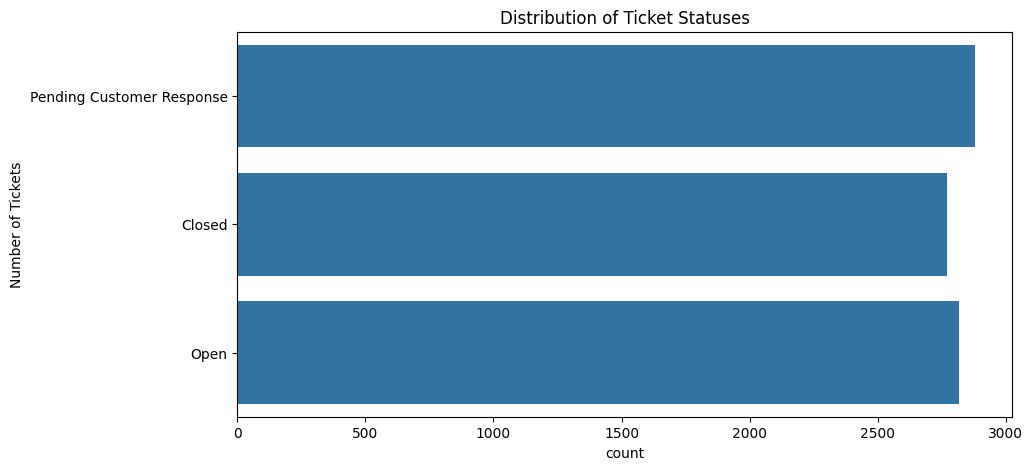

In [17]:
print(f"Closed Tickets: {df[df['Ticket Status'] == 'Closed'].shape[0]}\nOthers: {df[df['Ticket Status'] != 'Closed'].shape[0]}\n")

plt.figure(figsize=(10,5))
sns.countplot(df['Ticket Status'] )
plt.title('Distribution of Ticket Statuses')
plt.ylabel('Number of Tickets')
plt.show()


### Check for Closed Tickets status without Satisfaction Rating

In [18]:
closed_tickets = df[(df['Ticket Status'] == 'Closed') & (df['Customer Satisfaction Rating'].isna())].shape[0]
print('Closed Tickets without Satisfaction Rating: ', closed_tickets )

Closed Tickets without Satisfaction Rating:  0


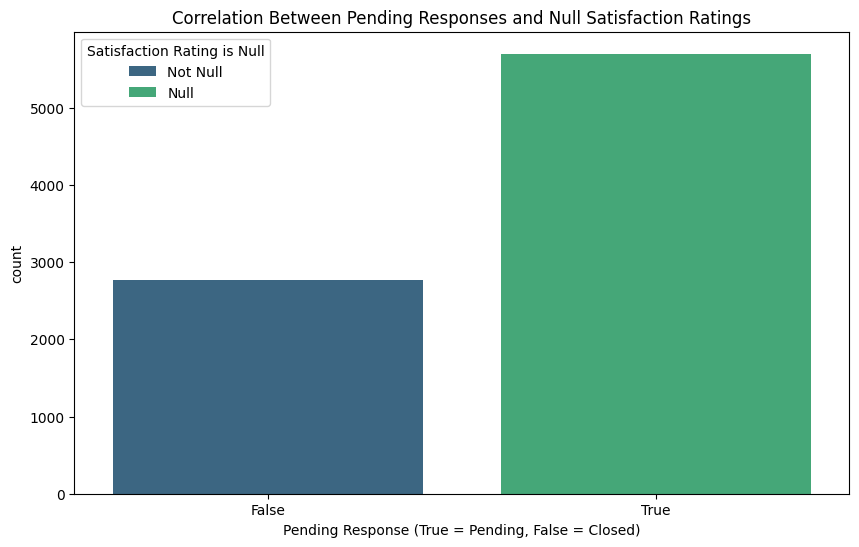

In [19]:
df['Pending Response'] = df['Ticket Status'] != 'Closed'

plt.figure(figsize=(10,6))
sns.countplot( x=df['Pending Response'], hue=df['Customer Satisfaction Rating'].isna(), palette="viridis")
plt.title("Correlation Between Pending Responses and Null Satisfaction Ratings")
plt.xlabel("Pending Response (True = Pending, False = Closed)")
plt.legend(title="Satisfaction Rating is Null", labels=["Not Null", "Null"])
plt.show()

### Distribution Of Customer Satisfation Rating

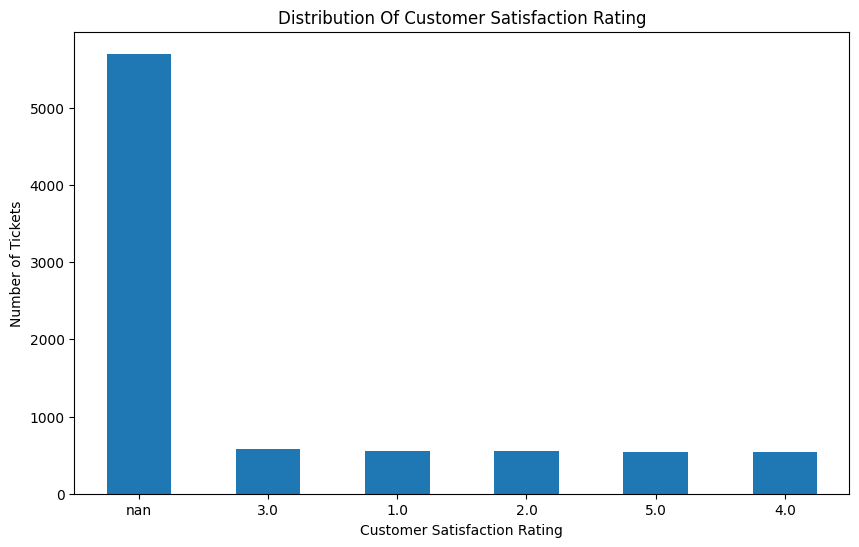

In [20]:
plt.figure(figsize=(10,6))
df['Customer Satisfaction Rating'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution Of Customer Satisfaction Rating')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=0)
plt.show()

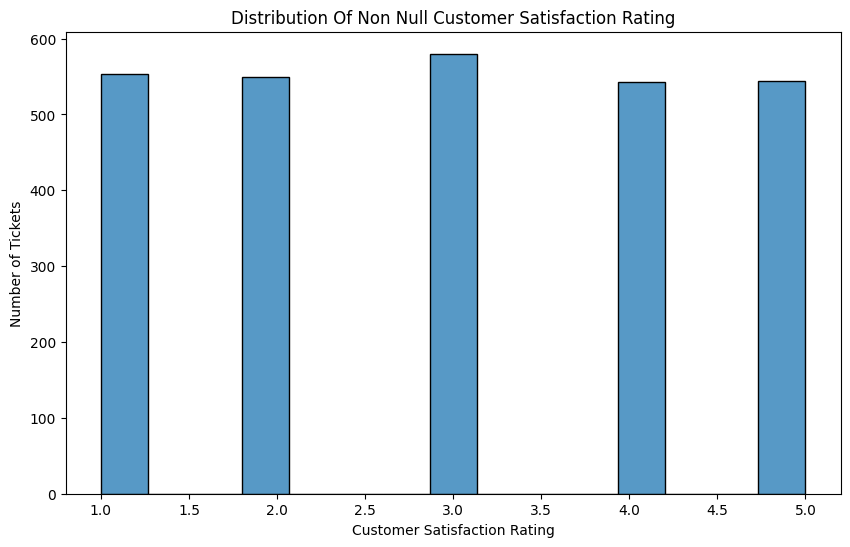

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(data=df['Customer Satisfaction Rating'])
plt.title('Distribution Of Non Null Customer Satisfaction Rating')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=0)
plt.show()

### Ticket trend over time

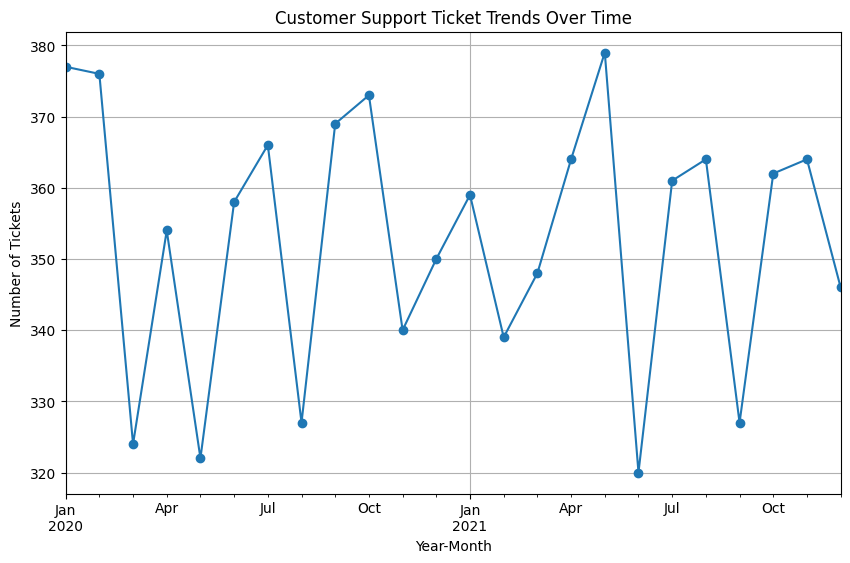

In [22]:
df['YearMonth'] = df['Date of Purchase'].dt.to_period('M')
ticket_trends = df.groupby('YearMonth').size()

plt.figure(figsize=(10, 6))
ticket_trends.plot(kind='line', marker='o')
plt.title('Customer Support Ticket Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tickets')
plt.grid(True)
plt.show()


### Distribution Of Ticket Priority

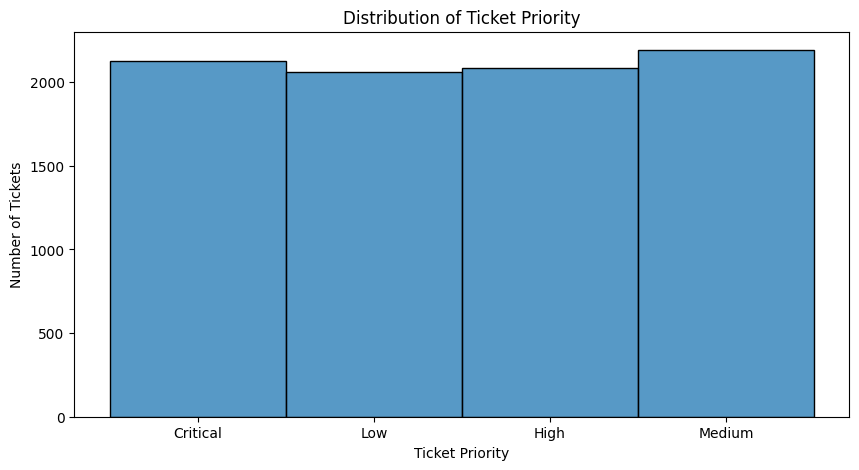

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(data=df['Ticket Priority'])
plt.ylabel('Number of Tickets')
plt.title('Distribution of Ticket Priority')
plt.show()

### Distribution of Ticket Channel

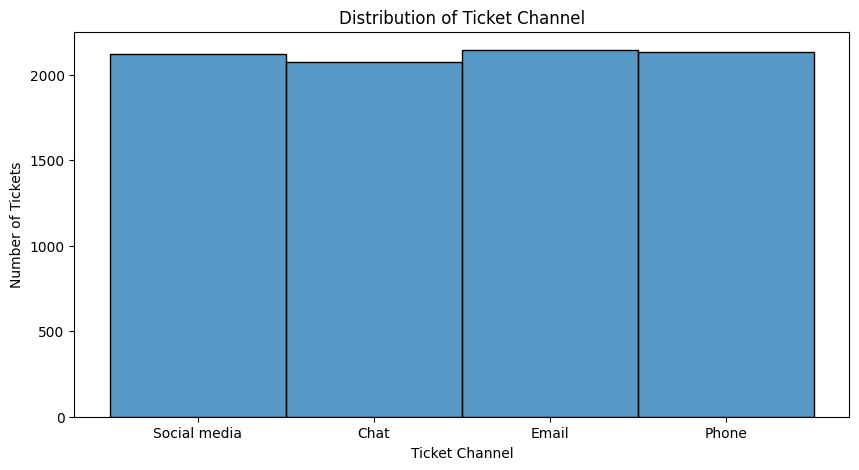

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(data=df['Ticket Channel'])
plt.ylabel('Number of Tickets')
plt.title('Distribution of Ticket Channel')
plt.show()

### Ticket Subject Vs Satisfaction Rating

C:\Users\daisy\AppData\Local\Temp\ipykernel_7880\3806688168.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticket Subject', y='Customer Satisfaction Rating', data= df[df['Ticket Subject'].isin(top_ticket_subjects.index)], palette='viridis')


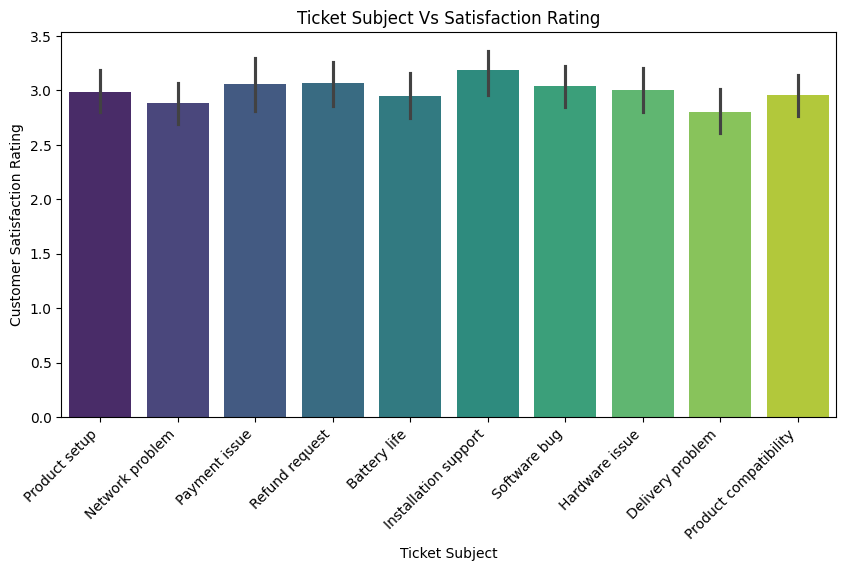

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='Ticket Subject', y='Customer Satisfaction Rating', data= df[df['Ticket Subject'].isin(top_ticket_subjects.index)], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Ticket Subject Vs Satisfaction Rating')
plt.show()

### Gender vs Satisfaction Rating Distribution 

Text(0.5, 1.0, 'Gender Distribution')

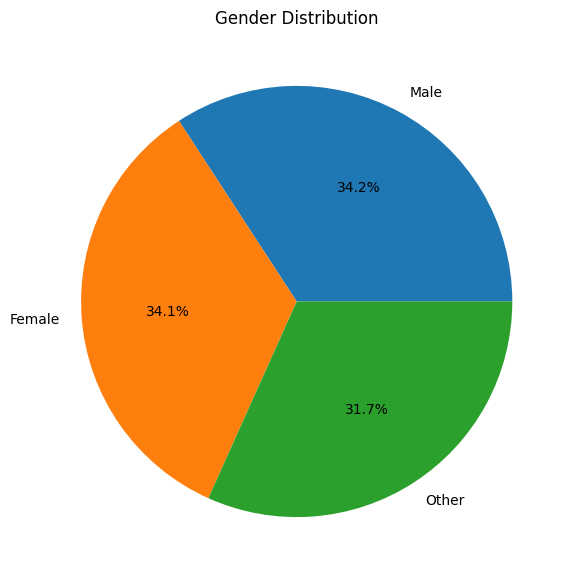

In [26]:
plt.figure(figsize=(7,7))
gender_data = df['Customer Gender'].value_counts()
plt.pie(gender_data, labels= gender_data.index, autopct='%1.1f%%' )
plt.title('Gender Distribution')

<Figure size 1000x600 with 0 Axes>

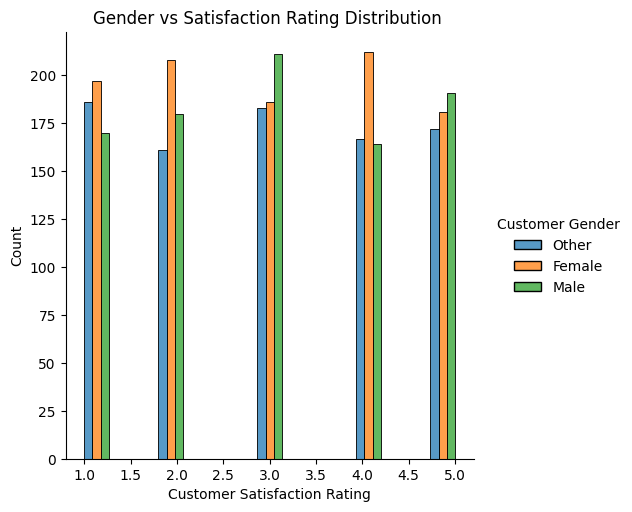

In [27]:
plt.figure(figsize=(10,6))
sns.displot(df, x='Customer Satisfaction Rating', hue='Customer Gender', multiple='dodge')
plt.title('Gender vs Satisfaction Rating Distribution ')
plt.show()

In [28]:
bins=[0, 20, 30,40,50,60,70,80,90, 100]
labels= ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df['Age Group'] =pd.cut(df['Customer Age'], bins=bins, labels=labels)

C:\Users\daisy\AppData\Local\Temp\ipykernel_7880\2399854295.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tickets_by_age_groups=df.groupby('Age Group').size()


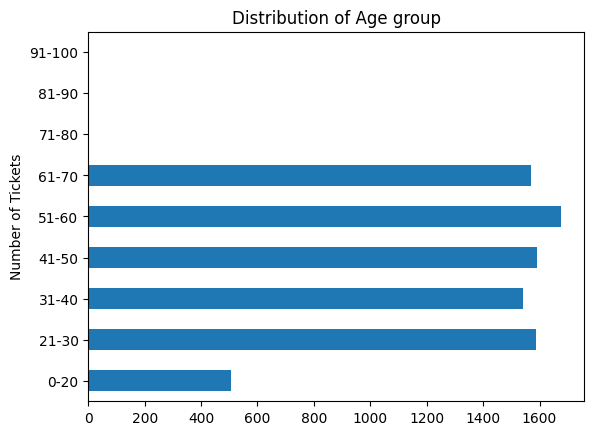

In [29]:
tickets_by_age_groups=df.groupby('Age Group').size()
tickets_by_age_groups.plot(kind='barh')
plt.ylabel('Number of Tickets')
plt.title('Distribution of Age group')
plt.show()

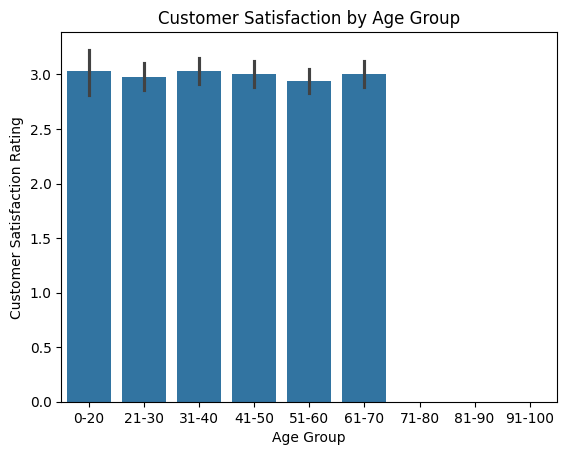

In [30]:
sns.barplot(x=df['Age Group'], y=df['Customer Satisfaction Rating'], data=df)
plt.title("Customer Satisfaction by Age Group")
plt.show()

# Feature Engineering

In [31]:
df.head(5)

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Pending Response,YearMonth,Age Group
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaT,NaN,True,2021-03,31-40
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaT,NaN,True,2021-05,41-50
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,False,2020-07,41-50
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,False,2020-11,21-30
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,False,2020-02,61-70


In [32]:
df['Resolution Time'] = ((df['Time to Resolution']- df['First Response Time'] ).dt.total_seconds()/3600).abs()
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,...,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Pending Response,YearMonth,Age Group,Resolution Time
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,...,NaN,Critical,Social media,2023-06-01 12:15:36,NaT,NaN,True,2021-03,31-40,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,...,NaN,Critical,Chat,2023-06-01 16:45:38,NaT,NaN,True,2021-05,41-50,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,...,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,False,2020-07,41-50,6.850000
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,...,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,False,2020-11,21-30,5.533333
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,...,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,False,2020-02,61-70,19.683333


## Encoding Where Necessary

In [33]:
le = LabelEncoder()
df['Ticket Priority Encoded'] = le.fit_transform(df['Ticket Priority'])
df['Customer Gender'] = le.fit_transform(df['Customer Gender'])
df['Pending Response'] = le.fit_transform(df['Pending Response'])


In [34]:


nominal_cols=['Ticket Channel', 'Ticket Type',	'Ticket Subject']
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ],
    remainder='passthrough'
) 

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])



df_transformed =  pipeline.fit_transform(df)
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names_out(nominal_cols)

non_nominal_cols = [col for col in df.columns if col not in nominal_cols]

df_encoded = pd.DataFrame(df_transformed, columns=list(ohe_feature_names)+non_nominal_cols)
df_encoded.index = df.index

df_encoded[ohe_feature_names] =df_encoded[ohe_feature_names].apply(pd.to_numeric)
# Preserve the data types of non-nominal columns
for col in non_nominal_cols:
    df_encoded[col] = df[col]
    
df_encoded['Customer Satisfaction Rating']=df_encoded['Customer Satisfaction Rating'].fillna(0).infer_objects(copy=False)
df_encoded['Resolution Time']=df_encoded['Resolution Time'].fillna(-1).infer_objects(copy=False)
df_encoded['Purchase Month'] = df_encoded['Date of Purchase'].dt.month
df_encoded.head()

pd.set_option('display.max_rows', None) 
print(df_encoded.dtypes)


Ticket Channel_Chat                               float64
Ticket Channel_Email                              float64
Ticket Channel_Phone                              float64
Ticket Channel_Social media                       float64
Ticket Type_Billing inquiry                       float64
Ticket Type_Cancellation request                  float64
Ticket Type_Product inquiry                       float64
Ticket Type_Refund request                        float64
Ticket Type_Technical issue                       float64
Ticket Subject_Account access                     float64
Ticket Subject_Battery life                       float64
Ticket Subject_Cancellation request               float64
Ticket Subject_Data loss                          float64
Ticket Subject_Delivery problem                   float64
Ticket Subject_Display issue                      float64
Ticket Subject_Hardware issue                     float64
Ticket Subject_Installation support               float64
Ticket Subject

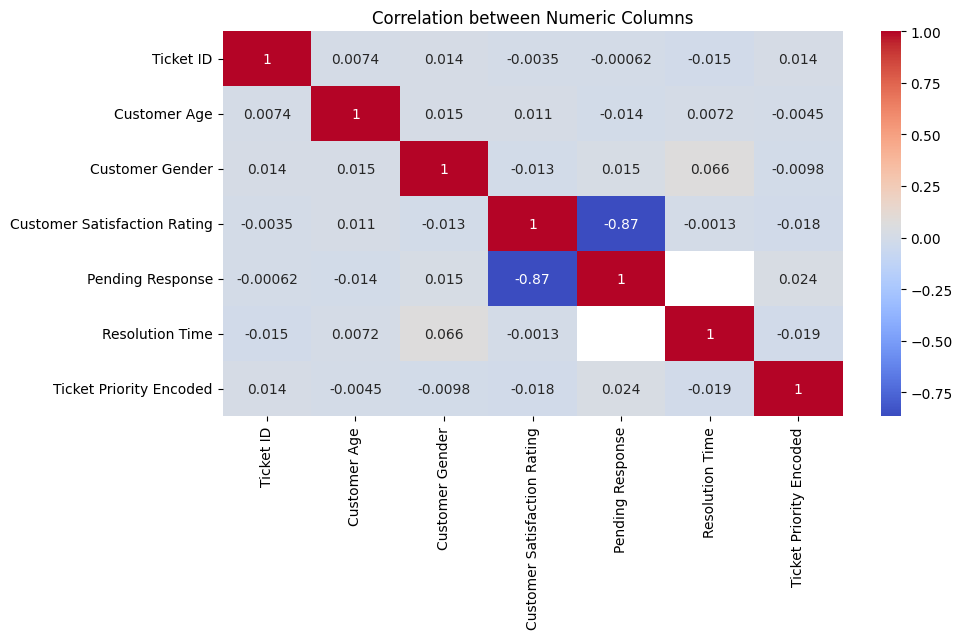

In [35]:
df['Customer Satisfaction Rating'] = df['Customer Satisfaction Rating'].fillna(0)
corr =df.corr(numeric_only=True)

plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Numeric Columns')
plt.show()

## Train-Test Split

In [36]:
resolved_cases = df_encoded[df_encoded['Ticket Status'] == 'Closed']
print(resolved_cases.shape)
X = resolved_cases.drop(columns=['Customer Satisfaction Rating', 'Resolution', 'Product Purchased', 'Ticket ID', 'Customer Name', 'Customer Email', 'Time to Resolution', 'First Response Time', 'Ticket Description', 'Date of Purchase', 'Ticket Priority', 'YearMonth', 'Age Group','Ticket Status', 'Ticket Priority Encoded'])
y =resolved_cases['Customer Satisfaction Rating'].astype(int)

# Split into training set and temp set
X_train, X_temp, y_train, y_temp =train_test_split(X, y, test_size=0.2, random_state=42)

#Split into validation and test set
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

(2769, 45)


# Model Building And Evaluation

## Baseline: Logic Regression 

In [37]:
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000000)
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_valid)
lr_mae = mean_absolute_error(y_valid, lr_predictions)
print('Linear Regression MAE: ', lr_mae)
print("Accuracy:", accuracy_score(y_valid, lr_predictions))
print(classification_report(y_valid, lr_predictions))

C:\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear Regression MAE:  1.6823104693140793
Accuracy: 0.18050541516245489
              precision    recall  f1-score   support

           1       0.16      0.14      0.15        58
           2       0.17      0.24      0.20        49
           3       0.22      0.28      0.25        54
           4       0.18      0.18      0.18        57
           5       0.14      0.08      0.11        59

    accuracy                           0.18       277
   macro avg       0.18      0.18      0.18       277
weighted avg       0.17      0.18      0.17       277



## Random Forest

In [38]:
rf_model = RandomForestClassifier(n_estimators=150, random_state=60)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_valid)
rf_mae = mean_absolute_error(y_valid, rf_predictions)
print("Accuracy:", accuracy_score(y_valid, rf_predictions))
print(classification_report(y_valid, rf_predictions))
print('Random Forest MAE: ', rf_mae)

Accuracy: 0.19494584837545126
              precision    recall  f1-score   support

           1       0.18      0.17      0.18        58
           2       0.20      0.22      0.21        49
           3       0.17      0.19      0.18        54
           4       0.24      0.21      0.22        57
           5       0.20      0.19      0.19        59

    accuracy                           0.19       277
   macro avg       0.20      0.20      0.20       277
weighted avg       0.20      0.19      0.20       277

Random Forest MAE:  1.5812274368231047


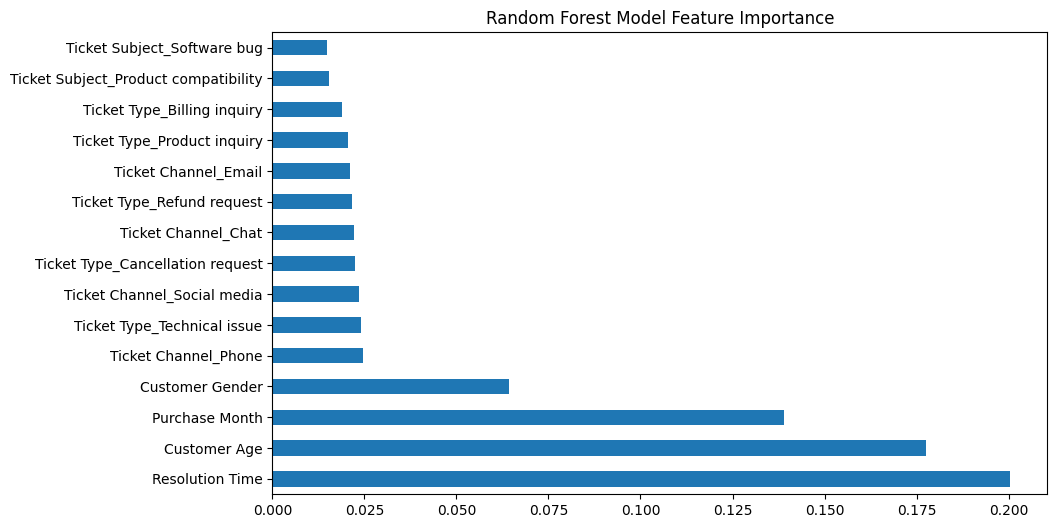

In [39]:
rf_importances = pd.Series(rf_model.feature_importances_, index = X.columns).sort_values(ascending=False).nlargest(15)

rf_importances.plot(kind='barh', figsize=(10,6))
plt.title('Random Forest Model Feature Importance')
plt.show()

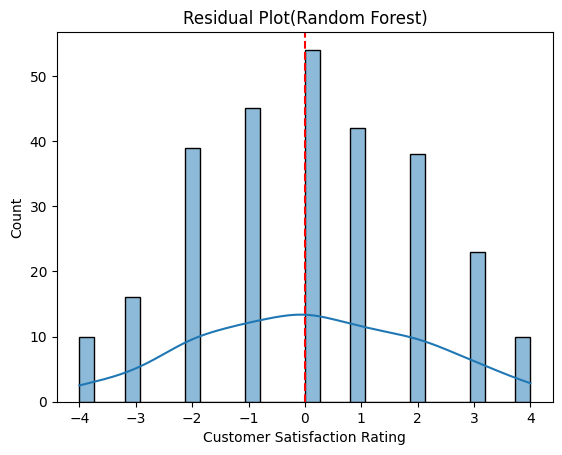

In [40]:
rf_residuals = y_valid - rf_predictions

sns.histplot(rf_residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Plot(Random Forest)')
plt.show()


## XGBoost

In [41]:
y_train_adj = y_train - 1
y_valid_adj = y_valid - 1
xgb_model = xgb.XGBClassifier(n_estimators=280, random_state=60, num_class=5)
xgb_model.fit(X_train, y_train_adj)

xgb_predictions = xgb_model.predict(X_valid)
xgb_mae = mean_absolute_error(y_valid_adj, xgb_predictions)
print("Accuracy:", accuracy_score(y_valid_adj, xgb_predictions))
print('XGBoost Mae: ', xgb_mae )
print(classification_report(y_valid_adj, xgb_predictions))

Accuracy: 0.16967509025270758
XGBoost Mae:  1.660649819494585
              precision    recall  f1-score   support

           0       0.17      0.16      0.16        58
           1       0.16      0.18      0.17        49
           2       0.20      0.22      0.21        54
           3       0.15      0.14      0.14        57
           4       0.17      0.15      0.16        59

    accuracy                           0.17       277
   macro avg       0.17      0.17      0.17       277
weighted avg       0.17      0.17      0.17       277



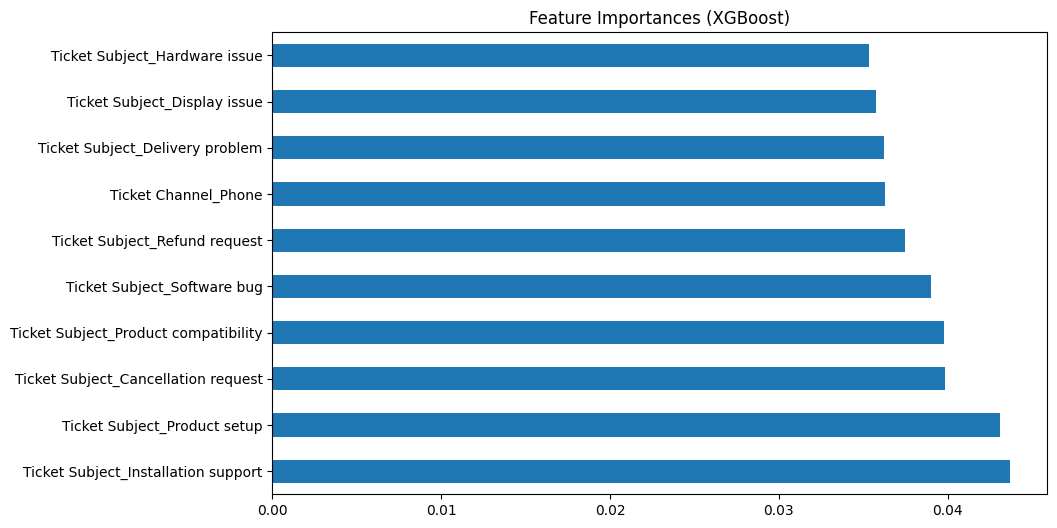

In [42]:
feature_importances = pd.Series(xgb_model.feature_importances_ , index=X.columns).sort_values(ascending=False).head(10)


feature_importances.plot(kind='barh', figsize=(10,6))
plt.title('Feature Importances (XGBoost)')
plt.show()

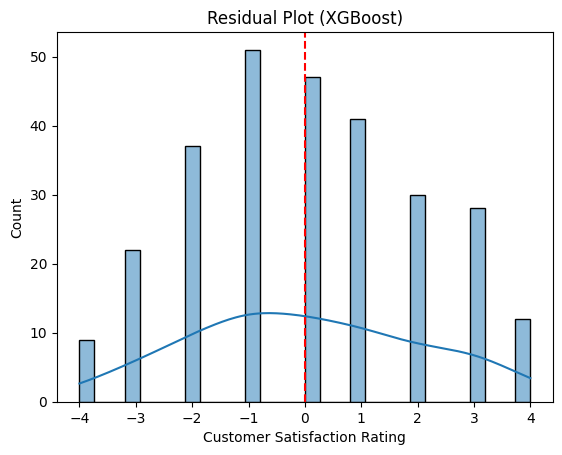

In [43]:
xgb_residuals = y_valid_adj - xgb_predictions

sns.histplot(xgb_residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Plot (XGBoost)')
plt.show()


## Light GBM

In [44]:
lgb_model = lgb.LGBMClassifier(n_estimators=370, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_valid)
lgb_mae = mean_absolute_error(y_valid, lgb_predictions)
print('Light GBM Mae: ', lgb_mae)
print("Accuracy:", accuracy_score(y_valid, lgb_predictions))
print(classification_report(y_valid, lgb_predictions))

C:\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Python\Python311\Lib\subprocess.py", line 1493, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
  

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 2215, number of used features: 29
[LightGBM] [Info] Start training from score -1.607183
[LightGBM] [Info] Start training from score -1.634582
[LightGBM] [Info] Start training from score -1.554539
[LightGBM] [Info] Start training from score -1.627662
[LightGBM] [Info] Start training from score -1.625365
Light GBM Mae:  1.6570397111913358
Accuracy: 0.18411552346570398
              precision    recall  f1-score   support

           1       0.18      0.17      0.18        58
           2       0.13      0.14      0.14        49
           3       0.23      0.22      0.22        54
           4       0.17      0.18      0.17        57
           5       0.21    

In [45]:
cv_scores = cross_val_score(lgb_model, 
                            X_train, y_train, scoring='accuracy',  cv=5)

print("Cross-Validation Accuracy:", cv_scores)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 29
[LightGBM] [Info] Start training from score -1.607746
[LightGBM] [Info] Start training from score -1.636320
[LightGBM] [Info] Start training from score -1.552938
[LightGBM] [Info] Start training from score -1.627662
[LightGBM] [Info] Start training from score -1.624792
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number

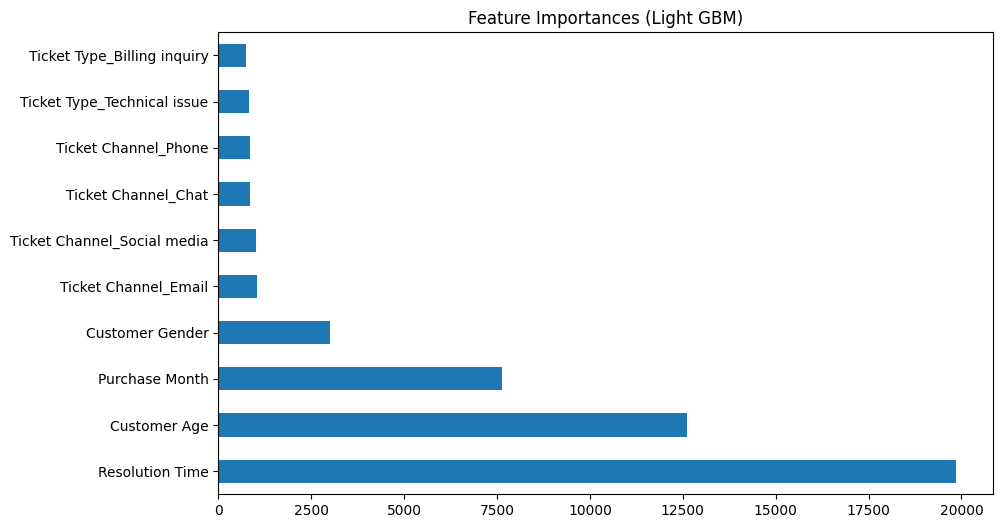

In [46]:
feature_importances = pd.Series(lgb_model.feature_importances_ , index=X.columns).sort_values(ascending=False).head(10)


feature_importances.plot(kind='barh', figsize=(10,6))
plt.title('Feature Importances (Light GBM)')
plt.show()

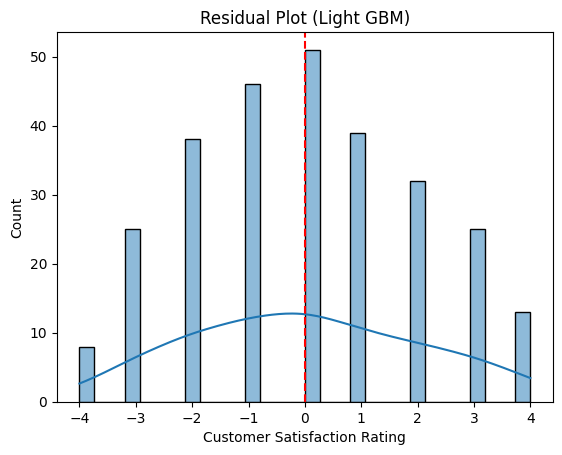

In [47]:
lgb_residuals = y_valid - lgb_predictions

sns.histplot(lgb_residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Plot (Light GBM)')
plt.show()


## Ordinal Regression

In [48]:
# Define parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]  # smaller = less regularization
}

# Model
ord_model = LogisticAT()

# Grid Search
grid = GridSearchCV(ord_model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

ord_pred = grid.predict(X_test)
print("Best alpha:", grid.best_params_['alpha'])
print("Accuracy:", accuracy_score(y_test, ord_pred))
print("MAE:", mean_absolute_error(y_test, ord_pred))

Best alpha: 100.0
Accuracy: 0.20938628158844766
MAE: 1.151624548736462


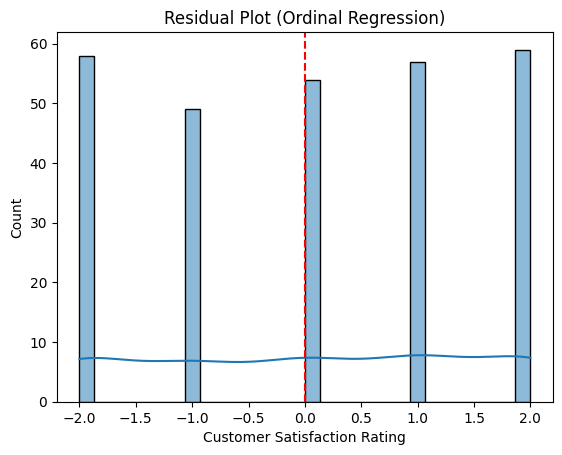

In [49]:
rf_residuals = y_valid - ord_pred

sns.histplot(rf_residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Plot (Ordinal Regression)')
plt.show()

## Confusion Matrices

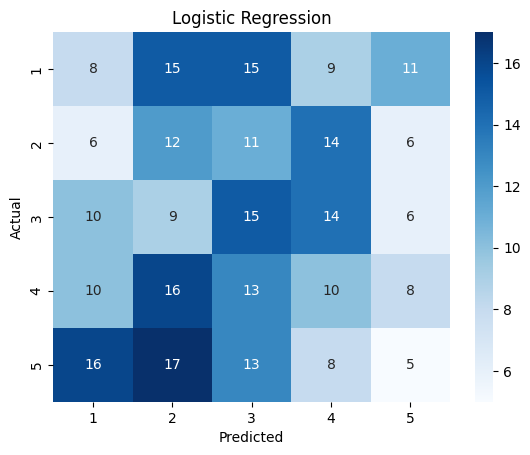

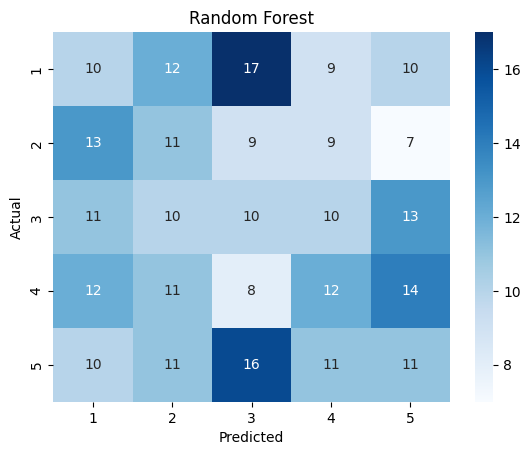

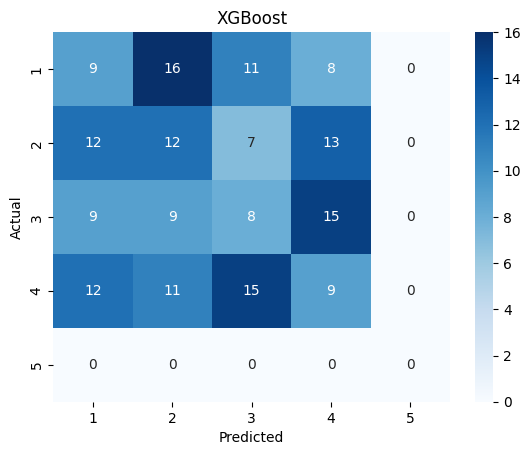

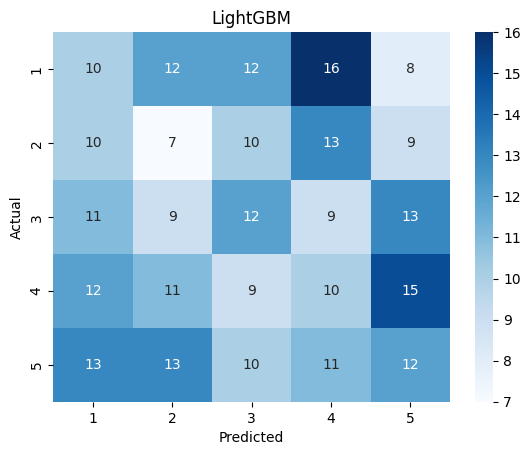

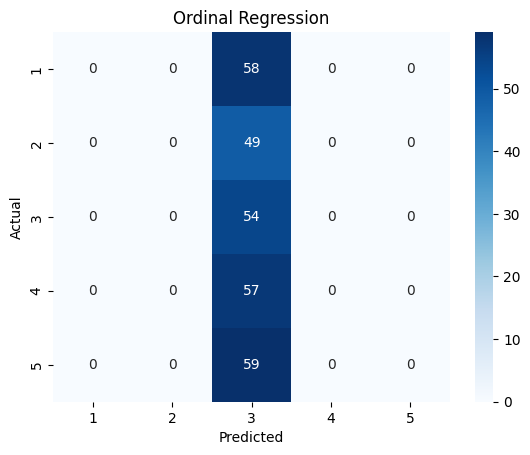

In [50]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_valid, lr_predictions, "Logistic Regression")
plot_conf_matrix(y_valid, rf_predictions, "Random Forest")
plot_conf_matrix(y_valid_adj, xgb_predictions, "XGBoost")
plot_conf_matrix(y_valid, lgb_predictions, "LightGBM")
plot_conf_matrix(y_valid, ord_pred, "Ordinal Regression")

## Final Model Test (Light GBM)

In [51]:
lgb_pred = lgb_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, lgb_pred))
print('MAE: ', mean_absolute_error(y_test, lgb_pred))
print(classification_report(y_test, lgb_pred)) 

Accuracy:  0.23465703971119134
MAE:  1.5451263537906137
              precision    recall  f1-score   support

           1       0.20      0.22      0.21        51
           2       0.34      0.26      0.30        68
           3       0.22      0.24      0.23        58
           4       0.22      0.20      0.21        51
           5       0.20      0.24      0.22        49

    accuracy                           0.23       277
   macro avg       0.24      0.23      0.23       277
weighted avg       0.24      0.23      0.24       277



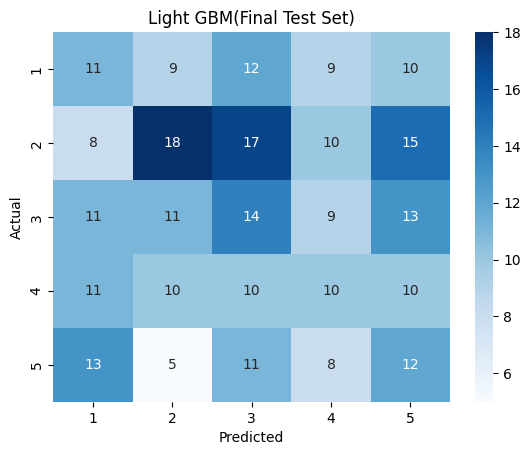

In [52]:
plot_conf_matrix(y_test, lgb_pred, "Light GBM(Final Test Set)")

## Final Model Test (Random Forest)

In [53]:
rf_pred = rf_model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, rf_pred))
print('MAE: ', mean_absolute_error(y_test, rf_pred))
print(classification_report(y_test, rf_pred)) 

Accuracy:  0.22743682310469315
MAE:  1.51985559566787
              precision    recall  f1-score   support

           1       0.24      0.29      0.26        51
           2       0.27      0.15      0.19        68
           3       0.27      0.31      0.29        58
           4       0.16      0.16      0.16        51
           5       0.20      0.24      0.22        49

    accuracy                           0.23       277
   macro avg       0.23      0.23      0.22       277
weighted avg       0.23      0.23      0.22       277



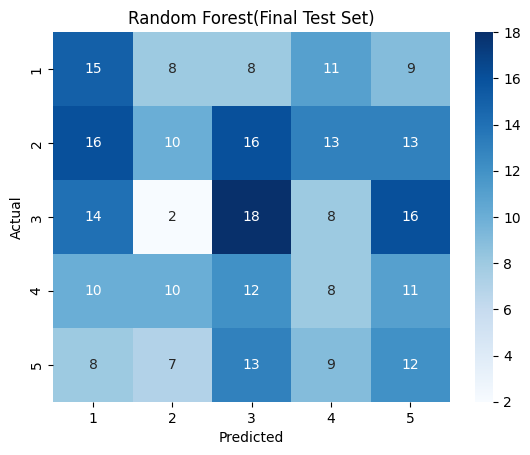

In [54]:
plot_conf_matrix(y_test, rf_pred, "Random Forest(Final Test Set)")

## Including Unresolved Tickets

In [55]:
X = df_encoded.drop(columns=['Customer Satisfaction Rating', 'Resolution', 'Product Purchased', 'Ticket ID', 'Customer Name', 'Customer Email', 'Time to Resolution', 'First Response Time', 'Ticket Description', 'Date of Purchase', 'Ticket Priority', 'YearMonth', 'Age Group','Ticket Status', 'Ticket Priority Encoded'])
y =df_encoded['Customer Satisfaction Rating'].astype(int)

# Split into training set and temp set
X_train, X_valid, y_train, y_valid_all =train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
rf_model = RandomForestClassifier(n_estimators=150, random_state=60)
rf_model.fit(X_train, y_train)

rf_all_predictions = rf_model.predict(X_valid)
rf_mae = mean_absolute_error(y_valid_all, rf_all_predictions)
print("Accuracy:", accuracy_score(y_valid_all, rf_all_predictions))
print(classification_report(y_valid_all, rf_all_predictions))
print('Random Forest MAE: ', rf_mae)

Accuracy: 0.7296340023612751
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1120
           1       0.22      0.23      0.23       115
           2       0.20      0.22      0.21       109
           3       0.22      0.23      0.23       117
           4       0.22      0.15      0.18       126
           5       0.15      0.18      0.16       107

    accuracy                           0.73      1694
   macro avg       0.34      0.34      0.33      1694
weighted avg       0.73      0.73      0.73      1694

Random Forest MAE:  0.5489964580873672


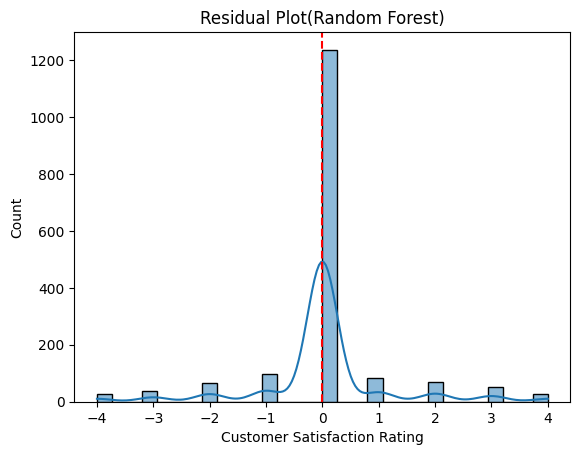

In [59]:
rf_residuals = y_valid_all - rf_all_predictions

sns.histplot(rf_residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Plot(Random Forest)')
plt.show()


In [60]:
lgb_model = lgb.LGBMClassifier(n_estimators=370, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_all_predictions = lgb_model.predict(X_valid)
lgb_mae = mean_absolute_error(y_valid_all, lgb_all_predictions)
print('Light GBM Mae: ', lgb_mae)
print("Accuracy:", accuracy_score(y_valid_all, lgb_all_predictions))
print(classification_report(y_valid_all, lgb_all_predictions))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 6775, number of used features: 30
[LightGBM] [Info] Start training from score -0.391540
[LightGBM] [Info] Start training from score -2.738776
[LightGBM] [Info] Start training from score -2.734220
[LightGBM] [Info] Start training from score -2.683268
[LightGBM] [Info] Start training from score -2.787908
[LightGBM] [Info] Start training from score -2.741061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

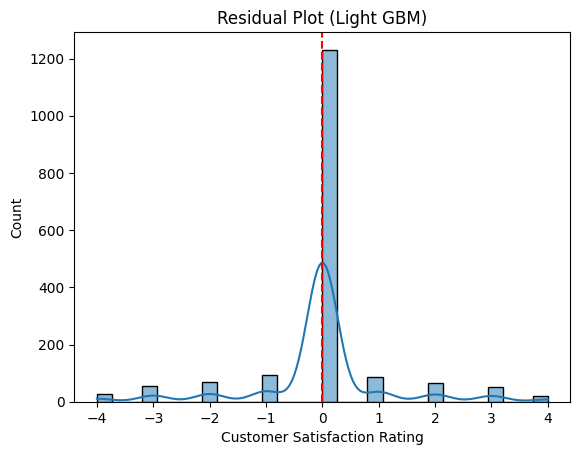

In [61]:
lgb_residuals = y_valid_all - lgb_all_predictions

sns.histplot(lgb_residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Plot (Light GBM)')
plt.show()


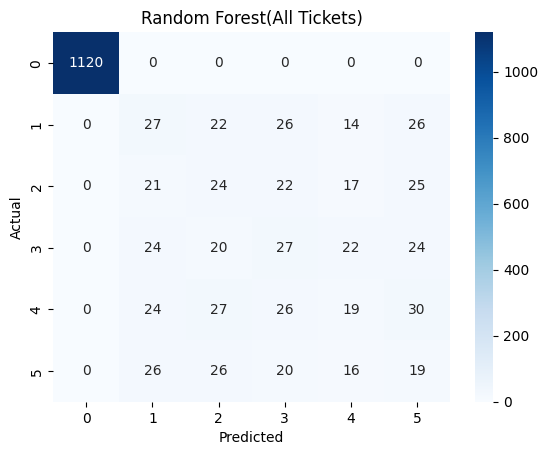

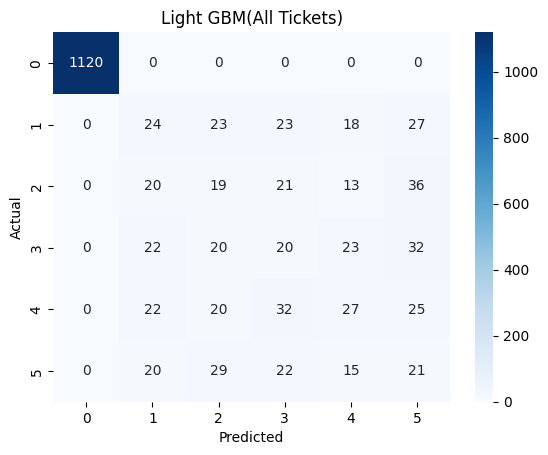

In [62]:
def plot_cm_all_tickets(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_cm_all_tickets(y_valid_all, rf_all_predictions, "Random Forest(All Tickets)")
plot_cm_all_tickets(y_valid_all, lgb_all_predictions, "Light GBM(All Tickets)")

In [63]:
predictions_df_resolved = pd.DataFrame({
    'actual_rating': y_valid,
    'predicted_rating': ord_pred
})
predictions_df_all = pd.DataFrame({
    'actual_rating': y_valid_all,
    'predicted_rating': rf_all_predictions
})
predictions_df_resolved.to_csv("../data/model_predictions_resolved.csv", index=False)
predictions_df_all.to_csv("../data/model_predictions_all.csv", index=False)
df_encoded.to_csv("../data/final_customer_support_dataset.csv", index=False)

# Conclusion

**Objective**  
To predict customer satisfaction ratings (1–5, with 0 for unresolved tickets) using support ticket data, enabling support teams to address low satisfaction issues.

## Insights

**Satisfaction Rating**  
- Most closed tickets were rated 3, showing that most ratings were neutral.
- Distribution of satisfaction rating among features such as Ticket Priority, Ticket Channel, Age Groups and Gender are about even.


**Feature Importance**  
- Models such as Light GBM, Random Forest, and XGBoost have indicated that **Resolution Time**, **Purchase Month**, **Customer Age and Gender**, and **Ticket Channel** are key features in determining predictions.


## Modeling

Models used:  
- Baseline: Logistic Regression, **Accuracy:** ~0.181,   **MAE:** ~1.68
- Random Forest Classifer, **Accuracy:** ~0.195 ,   **MAE:** ~1.58
- XGBoost Classifier, **Accuracy:** ~0.170,   **MAE:** ~1.66
- Light GBM Classifier, **Accuracy:** ~0.184,   **MAE:** ~1.66
- Ordinal Regression, **Accuracy:** ~0.209,   **MAE:** ~1.152

**Best Models:**  
- Even though Ordinal Regression outperformed all other models in terms of accuracy and MAE, it projected all values to be 3, which led to class imbalance.
- **Random Forest Classifier** and **Light GBM Classifier** were deemed the best models since they were unaffected by class imbalance. Their accuracy ratings against the test set were approximately **0.227** and **0.234**, respectively.

**Unresolved Tickets**  
- Model predictions for unresolved tickets were highly accurate; however, they did not perform as well for resolved tickets.
- Light GBM Classifier, **Accuracy:** ~0.727,   **MAE:** ~0.56
- Random Forest Classifer, **Accuracy:** ~0.730 ,   **MAE:** ~0.55
- Including unresolved tickets (0 class) improved general model performance by increasing data diversity — showing unresolved cases provide a strong signal.
